In [1]:
from pathlib import Path
from datetime import datetime, timedelta

import pandas as pd
import os
import json
import polars as pl
import matplotlib.pyplot as plt


ROOT_DIR = Path(os.getcwd()).parent

In [6]:
ticker = "STORJBTC"
time = "2018-12-08 18:45:00"

df_pump = df[
    (df["pumped_ticker"] == ticker) & (df["pump_time"] == time)
].copy()

In [9]:
num_cols = df_pump.columns[:-5]

In [6]:
from sklearn.preprocessing import StandardScaler

df_cross_pump = df_pump.copy()

df_cross_pump[num_cols] = StandardScaler().fit_transform(df_cross_pump[num_cols])
df_cross_pump.head(1)

,log_return_mean_1d,log_return_std_1d,log_return_skew_1d,log_return_kurt_1d,num_trades_mean_1d,num_trades_std_1d,num_trades_skew_1d,num_trades_kurt_1d,qty_abs_mean_1d,qty_abs_std_1d,...,qty_abs_kurt_30d,num_prev_pumps,imbalance_ratio_1d,imbalance_ratio_7d,imbalance_ratio_14d,imbalance_ratio_30d,ticker,pumped_ticker,pump_time,is_pumped
index,,,,,,,,,,,,,,,,,,,,,
0,1.50117,1.371099,-1.129745,-0.243982,-0.260185,-0.376102,-1.293459,-1.172665,0.250039,0.194646,...,1.103072,0.0,0.127952,0.149605,-0.115684,-0.032248,DGBBTC,AGIXBTC,2022-08-14 16:00:05+00:00,False


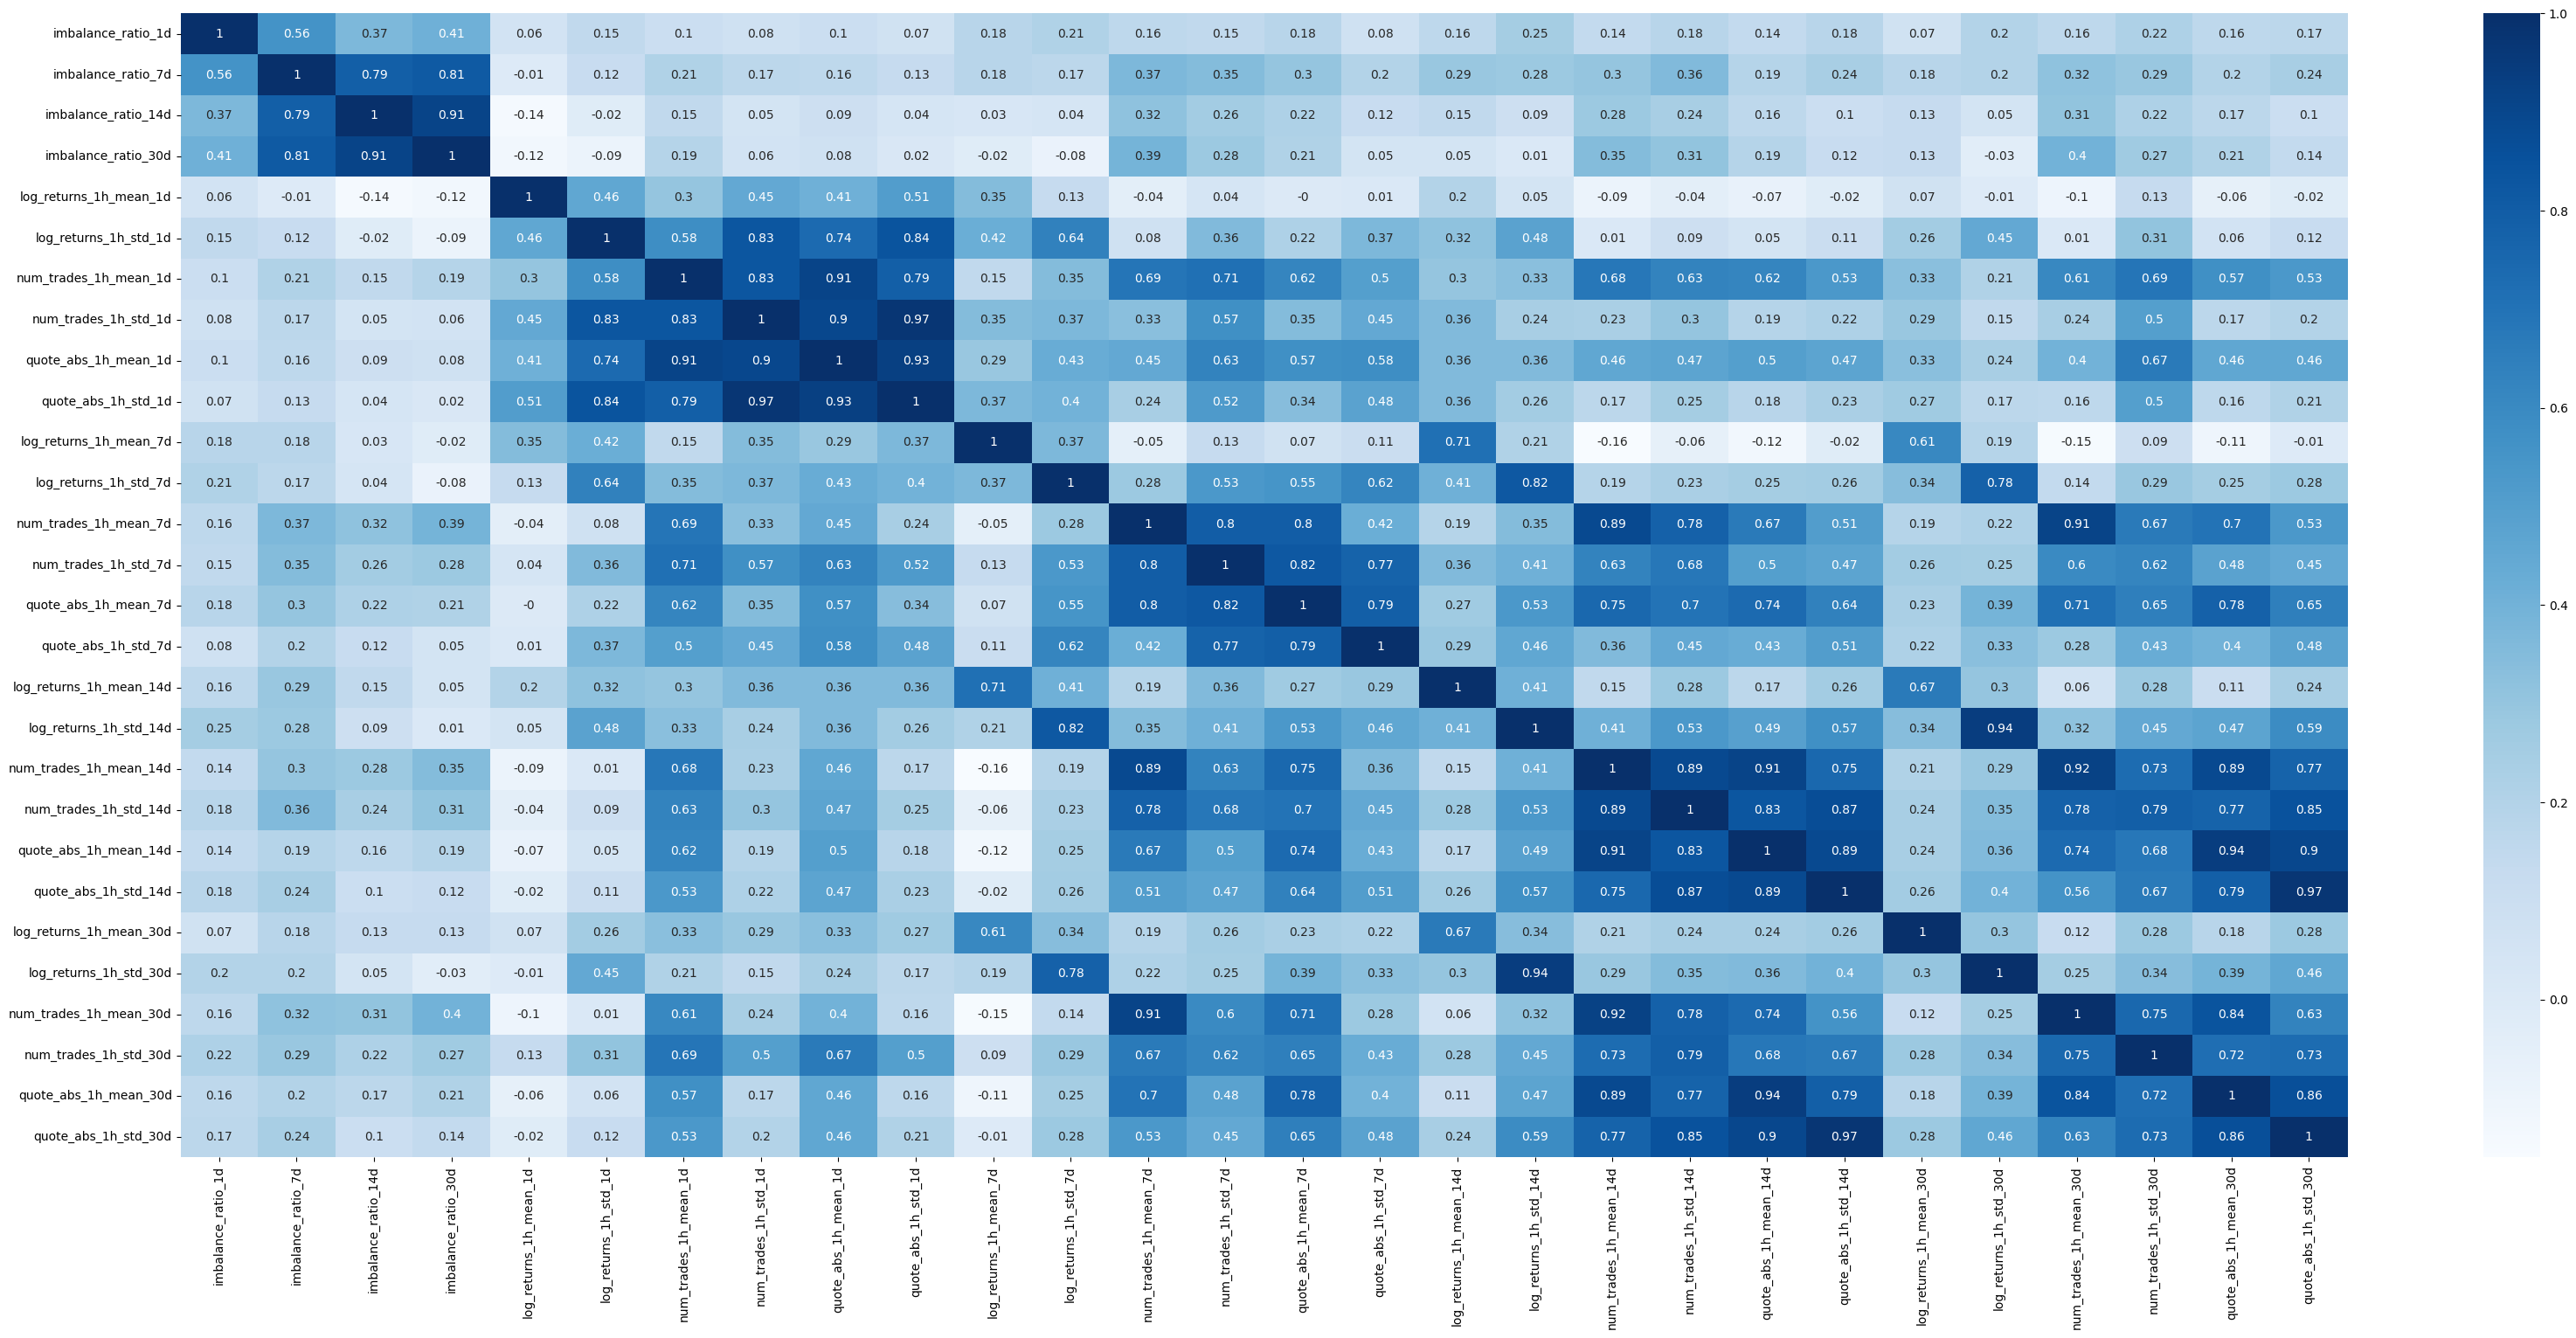

In [11]:
import seaborn as sns

plt.figure(figsize=(40, 17))

sns.heatmap(
    df_pump[num_cols].corr().round(2), annot=True, cmap=plt.cm.Blues
)

plt.show()

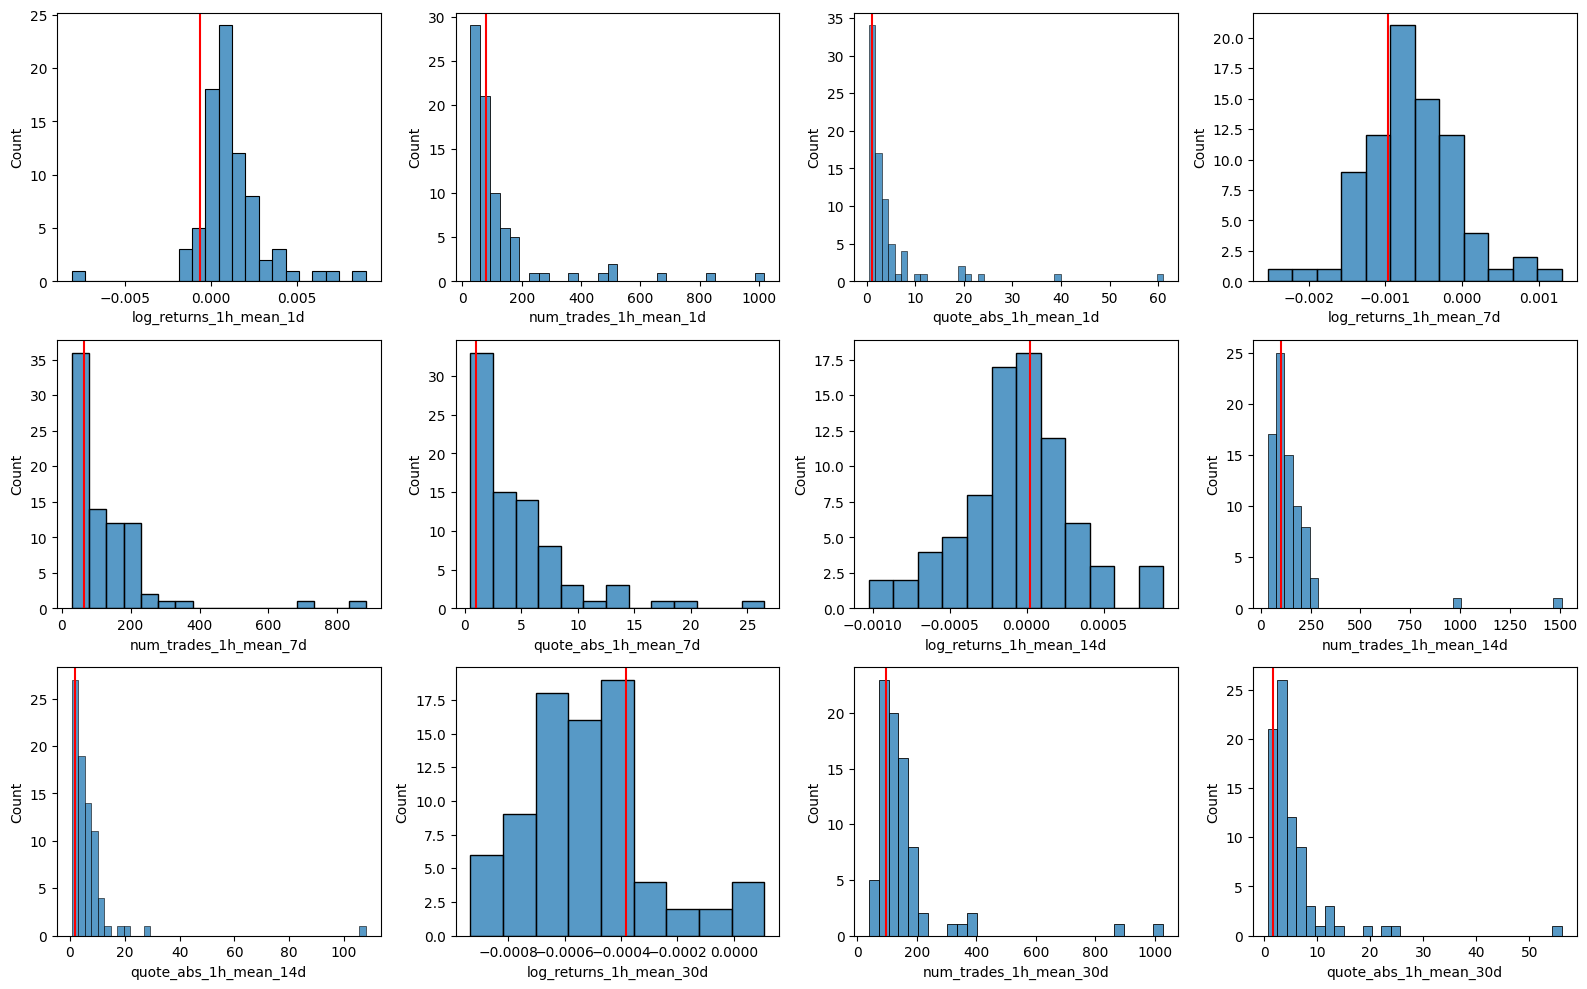

In [13]:
fig, axs = plt.subplots(3, 4, figsize=(16, 10)) 

axs = [ax for ax_list in axs for ax in ax_list]
cols = [col for col in df.columns if "mean" in col]


for ax, col in zip(axs, cols):
    sns.histplot(df_pump[col], ax=ax)
    ax.axvline(
        x=df_pump[df_pump["ticker"] == ticker][col].values[0], color="red"
    )

plt.tight_layout()
plt.show()

Берем тики аггерирую в df_trades. Основные тип фичей: log_return, num_trades, qty_quote_asset (BTC), imbalance_ratio, num_previous_pumps. Для каждой фичи используется окно (bins) 1 час, и считаю моменты по этим фичам за 1d, 7d, 14d, 30d до пампа. 

In [15]:
features = [
    "log_returns", "qty_abs", "num_trades"
] 

intervals = ["1d", "7d", "14d", "30d"]

df_mean_std = pd.DataFrame()

for feature in features:
    for interval in intervals:
        df_mean_std[f"{feature}_{interval}"] = df[f"{feature}_mean_{interval}"] / df[f"{feature}_std_30d"]

df_mean_std["ticker"] = df_pump["ticker"]
df_mean_std.head(1)

KeyError: 'log_returns_mean_1d'

In [10]:
df_mean_std = pd.DataFrame()

for interval in intervals:
    df_mean_std[f"log_return_{interval}"] = df[f"log_return_mean_{interval}"] / df["log_return_std_30d"]


for feature in ["qty_abs", "num_trades"]:
    for interval in intervals:
        df_mean_std[f"{feature}_{interval}"] = df[f"{feature}_mean_{interval}"] / df[f"{feature}_mean_30d"]

df_mean_std["ticker"] = df["ticker"]

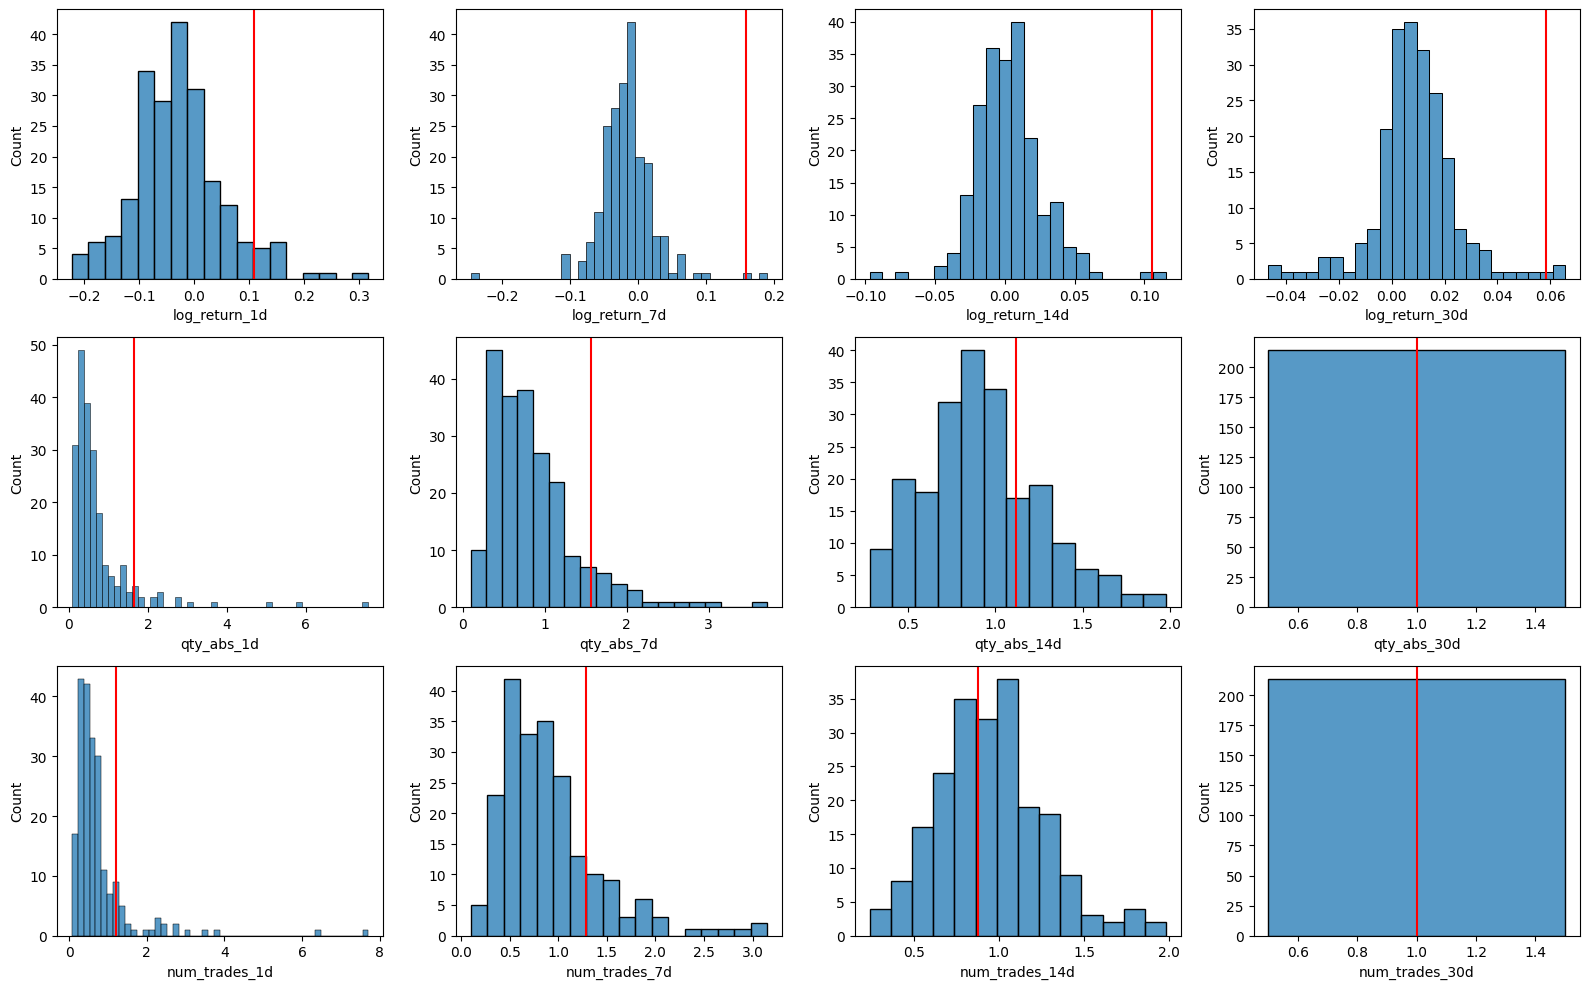

In [12]:
fig, axs = plt.subplots(3, 4, figsize=(16, 10))

axs = [ax for ax_list in axs for ax in ax_list]
cols = df_mean_std.columns[:-1]


for ax, col in zip(axs, cols):
    sns.histplot(df_mean_std[col], ax=ax)
    ax.axvline(
        x=df_mean_std[df_mean_std["ticker"] == ticker][col].values[0], color="red"
    )

plt.tight_layout()
plt.show()

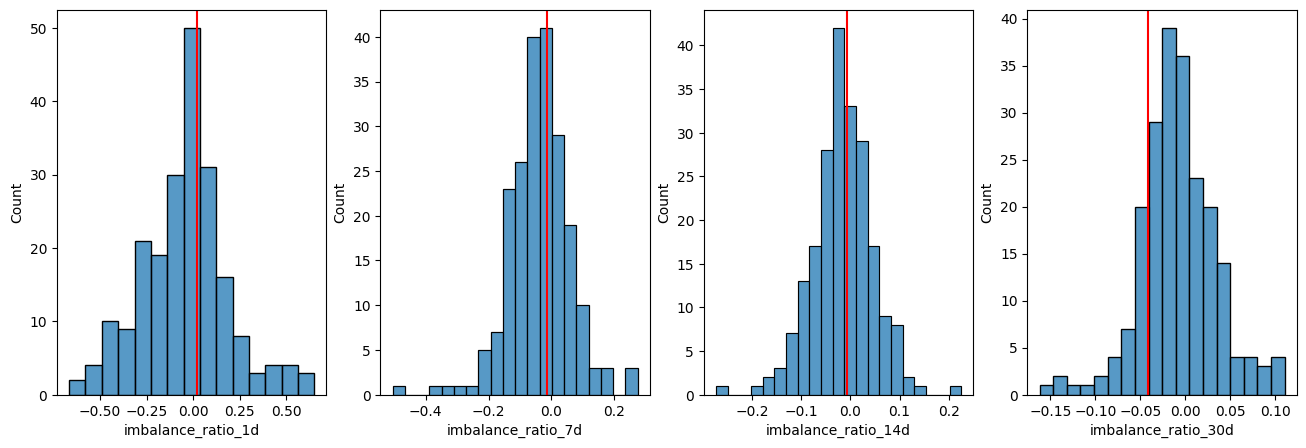

In [13]:
imbalance_cols = [
    col for col in df.columns if "imbalance" in col
]

fig, axs = plt.subplots(1, 4, figsize=(16, 5))

for col, ax in zip(imbalance_cols, axs):
    sns.histplot(ax=ax, data=df[col])
    ax.axvline(
        x=df[df["ticker"] == ticker][col].iloc[0], color="red"
    )

In [ ]:
df_pump.plot.scatter(x="log_return_mean_7d", y="log_return_mean_30d", figsize=(16, 10))
plt.axhline(y=0)
plt.axvline(x=0)
plt.show()

In [ ]:
sns.histplot(df_pump["mean_imbalance_1d"])
plt.axvline(
    x=df_pump[df_pump["ticker"] == ticker]["mean_imbalance_1d"].values[0], color="red"
)

plt.show()

In [ ]:
import numpy as np

np.exp(-2e-4 * 4 * 24 * 0)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X = StandardScaler().fit_transform(df_pump.iloc[:, :-4])

pca = PCA(n_components=X.shape[1])
PCA_proj = pca.fit_transform(X)

In [ ]:
plt.plot(
    pca.explained_variance_ratio_.cumsum()
)
plt.show()

In [ ]:
pca.explained_variance_ratio_[:2].sum()

In [ ]:
df_pca = pd.DataFrame(
    data=pca.components_.T
)

df_pca.index = df_pump.columns[:-4]
df_pca.columns = [f"PC_{i}" for i in range(1, len(df_pump.columns[:-4]) + 1)]

plt.figure(figsize=(16, 10))

sns.heatmap(
    df_pca.iloc[:, :10].round(3), annot=True
)

In [ ]:
df_pump["is_pumped"] = df_pump["ticker"] == ticker

colors = df_pump["is_pumped"].map({
    True: "black", False: "yellow"
}).tolist()

plt.scatter(
    PCA_proj[:, 0], PCA_proj[:, 1], color=colors, alpha=.5
)

plt.show()